In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
doenca_cardiaca = fetch_ucirepo(id=45)

In [ ]:
X = doenca_cardiaca.data.features
X = X[['age', 'chol', 'cp']]

# Criar variáveis dummy para a coluna 'cp'
df_cp = pd.get_dummies(X['cp'], prefix='cp')
X = X.drop('cp', axis=1).join(df_cp)

In [ ]:
target = doenca_cardiaca.data.targets
target = (target > 0) * 1

In [ ]:
entrada = tf.constant(X, dtype=tf.float32)
y = tf.constant(target, dtype=tf.float32)

In [ ]:
# Dividindo os dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(entrada.numpy(), y.numpy(), test_size=0.2, stratify=y.numpy(), random_state=4321)

In [ ]:
#Normalizando os dados
scaler = StandardScaler()
X_treino = scaler.fit_transform(X_treino)
X_teste = scaler.transform(X_teste)

# Convertendo para tensores do TensorFlow
X_treino = tf.constant(X_treino, dtype=tf.float32)
X_teste = tf.constant(X_teste, dtype=tf.float32)
y_treino = tf.constant(y_treino, dtype=tf.float32)
y_teste = tf.constant(y_teste, dtype=tf.float32)

In [ ]:
def obter_pesos_vies(tamanho_da_anterior, n_neuronios_nessa_camada):
  tf.random.set_seed(31)
  pesos_camada = tf.Variable(tf.random.normal([tamanho_da_anterior, n_neuronios_nessa_camada]))
  vieses_camada = tf.Variable(tf.random.normal([n_neuronios_nessa_camada]))
  return pesos_camada, vieses_camada

In [ ]:
quantidade_features = X_treino.shape[1]
pesos1, vies1 = obter_pesos_vies(quantidade_features, 3)
pesos2, vies2, = obter_pesos_vies(3, 1)

otimizador_treino = tf.optimizers.SGD(learning_rate=0.01)
QUANTIDADE_EPOCAS = 1000
calculadora_perda = tf.keras.losses.BinaryCrossentropy()

perdas_3_neuronios = []
taxas_acerto_3_neuronios = []

def neuronio(x, pesos, vies):
  z = tf.add(tf.matmul(x, pesos), vies)
  return z

for epoca in range(QUANTIDADE_EPOCAS):
  with tf.GradientTape() as tape:
    fim_da_primeira = tf.sigmoid(neuronio(X_treino, pesos1, vies1))
    fim_da_segunda = tf.sigmoid(neuronio(fim_da_primeira, pesos2, vies2))
    custo = calculadora_perda(y_treino, fim_da_segunda)

  fim_da_primeira_teste = tf.sigmoid(neuronio(X_teste, pesos1, vies1))
  fim_da_segunda_teste = tf.sigmoid(neuronio(fim_da_primeira_teste, pesos2, vies2))
  acertos = np.mean(y_teste.numpy() == ((fim_da_segunda_teste.numpy() > 0.5)*1))

  taxas_acerto_3_neuronios.append(acertos)
  perdas_3_neuronios.append(custo.numpy())

  gradientes = tape.gradient(custo, [pesos1, vies1, pesos2, vies2])
  otimizador_treino.apply_gradients(zip(gradientes, [pesos1, vies1, pesos2, vies2]))

In [ ]:
print(f'Menor custo obtido com 3 perceptrons: {min(perdas_3_neuronios)}')
print(f'Maior taxa de acerto obtida com 3 perceptrons: {max(taxas_acerto_3_neuronios)}')

Menor custo obtido com 3 perceptrons: 0.6089321970939636
Maior taxa de acerto obtida com 3 perceptrons: 0.7377049180327869


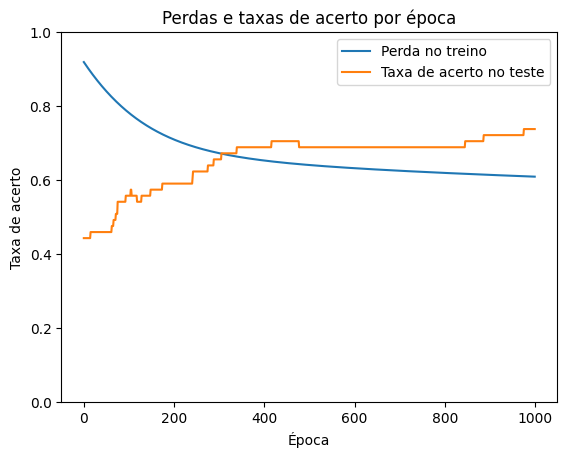

In [ ]:
plt.plot(perdas_3_neuronios)
plt.plot(taxas_acerto_3_neuronios)
plt.title('Perdas e taxas de acerto por época')
plt.legend(['Perda no treino', 'Taxa de acerto no teste'])
plt.xlabel('Época')
plt.ylabel('Taxa de acerto')
plt.ylim(0,1)
plt.show()

In [ ]:
def obter_pesos_vies(tamanho_entrada, tamanho_oculta1, tamanho_oculta2):
  tf.random.set_seed(31)

  pesos1 = tf.Variable(tf.random.normal([tamanho_entrada, tamanho_oculta1]))
  vies1 = tf.Variable(tf.random.normal([tamanho_oculta1]))

  pesos2 = tf.Variable(tf.random.normal([tamanho_oculta1, tamanho_oculta2]))
  vies2 = tf.Variable(tf.random.normal([tamanho_oculta2]))

  pesos_final = tf.Variable(tf.random.normal([tamanho_oculta2, 1]))
  vies_final = tf.Variable(tf.random.normal([1]))

  return pesos1, vies1, pesos2, vies2, pesos_final, vies_final

In [ ]:
variaveis = obter_pesos_vies(quantidade_features, 6, 4)
pesos1, vies1, pesos2, vies2, pesos_final, vies_final = variaveis

In [ ]:
otimizador_treino = tf.optimizers.SGD(learning_rate=0.01)

perdas = []
taxas_acerto = []

def neuronio(x, pesos, vies):
  return tf.add(tf.matmul(x, pesos), vies)

for epoca in range(QUANTIDADE_EPOCAS):
  with tf.GradientTape() as tape:
    treino1 = tf.sigmoid(neuronio(X_treino, pesos1, vies1))
    treino2 = tf.sigmoid(neuronio(treino1, pesos2, vies2))
    treino3 = tf.sigmoid(neuronio(treino2, pesos_final, vies_final))
    custo = calculadora_perda(y_treino, treino3)

  perdas.append(custo.numpy())

  teste1 = tf.sigmoid(neuronio(X_teste, pesos1, vies1))
  teste2 = tf.sigmoid(neuronio(teste1, pesos2, vies2))
  teste3 = tf.sigmoid(neuronio(teste2, pesos_final, vies_final))

  acertos = np.mean(y_teste.numpy() == ((teste3.numpy() > 0.5) *1))
  taxas_acerto.append(acertos)

  gradientes = tape.gradient(custo, variaveis)
  otimizador_treino.apply_gradients(zip(gradientes, variaveis))

In [ ]:
print(f'Menor custo obtido com duas camadas ocultas: {min(perdas)}')
print(f'Maior taxa de acerto obtida com duas camadas ocultas: {max(taxas_acerto)}')

Menor custo obtido com duas camadas ocultas: 0.6457715034484863
Maior taxa de acerto obtida com duas camadas ocultas: 0.7049180327868853


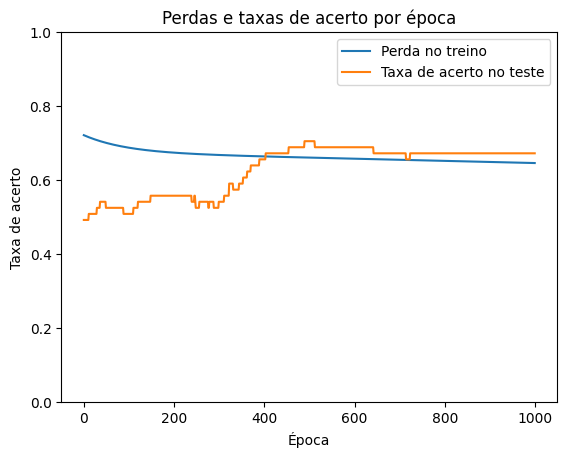

In [ ]:
plt.plot(perdas)
plt.plot(taxas_acerto)
plt.title('Perdas e taxas de acerto por época')
plt.legend(['Perda no treino', 'Taxa de acerto no teste'])
plt.xlabel('Época')
plt.ylabel('Taxa de acerto')
plt.ylim(0,1)
plt.show()

In [ ]:
variaveis = obter_pesos_vies(6,6,4)
pesos1, vies1, pesos2, vies2, pesos_final, vies_final = variaveis

otimizador_treino = tf.optimizers.SGD(learning_rate=0.01)

perdas = []
taxas_acerto = []

def neuronio(x, pesos, vies):
  return tf.add(tf.matmul(x, pesos), vies)

for epoca in range(QUANTIDADE_EPOCAS):
  with tf.GradientTape() as tape:
    treino1 = tf.nn.relu(neuronio(X_treino, pesos1, vies1))
    treino2 = tf.nn.relu(neuronio(treino1, pesos2, vies2))
    treino3 = tf.sigmoid(neuronio(treino2, pesos_final, vies_final))
    custo = calculadora_perda(y_treino, treino3)

  perdas.append(custo.numpy())

  teste1 = tf.nn.relu(neuronio(X_teste, pesos1, vies1))
  teste2 = tf.nn.relu(neuronio(teste1, pesos2, vies2))
  teste3 = tf.sigmoid(neuronio(teste2, pesos_final, vies_final))

  acertos = np.mean(y_teste.numpy() == ((teste3.numpy() > 0.5) *1))
  taxas_acerto.append(acertos)

  gradientes = tape.gradient(custo, variaveis)
  otimizador_treino.apply_gradients(zip(gradientes, variaveis))

In [ ]:
print(f'Menor custo obtido com ReLU nas camadas ocultas: {min(perdas)}')
print(f'Maior taxa de acerto obtida com ReLU nas camadas ocultas: {max(taxas_acerto)}')

Menor custo obtido com ReLU nas camadas ocultas: 0.5485773086547852
Maior taxa de acerto obtida com ReLU nas camadas ocultas: 0.7704918032786885


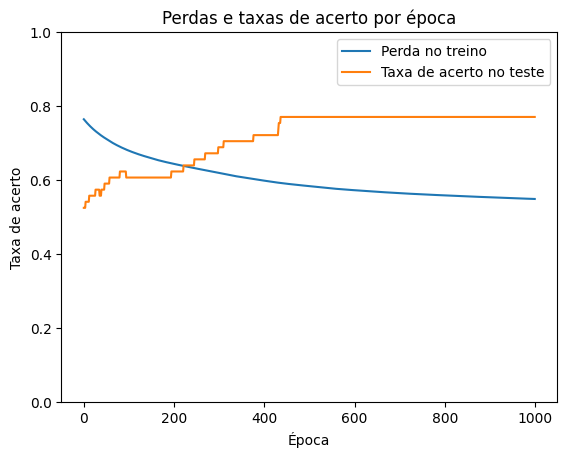

In [ ]:
plt.plot(perdas)
plt.plot(taxas_acerto)
plt.title('Perdas e taxas de acerto por época')
plt.legend(['Perda no treino', 'Taxa de acerto no teste'])
plt.xlabel('Época')
plt.ylabel('Taxa de acerto')
plt.ylim(0,1)
plt.show()

In [ ]:
variaveis = obter_pesos_vies(6,9,4)
pesos1, vies1, pesos2, vies2, pesos_final, vies_final = variaveis

otimizador_treino = tf.optimizers.SGD(learning_rate=0.01)

perdas = []
taxas_acerto = []

def neuronio(x, pesos, vies):
  return tf.add(tf.matmul(x, pesos), vies)

for epoca in range(QUANTIDADE_EPOCAS):
  with tf.GradientTape() as tape:
    treino1 = tf.nn.relu(neuronio(X_treino, pesos1, vies1))
    treino2 = tf.nn.relu(neuronio(treino1, pesos2, vies2))
    treino3 = tf.sigmoid(neuronio(treino2, pesos_final, vies_final))
    custo = calculadora_perda(y_treino, treino3)

  perdas.append(custo.numpy())

  teste1 = tf.nn.relu(neuronio(X_teste, pesos1, vies1))
  teste2 = tf.nn.relu(neuronio(teste1, pesos2, vies2))
  teste3 = tf.sigmoid(neuronio(teste2, pesos_final, vies_final))

  acertos = np.mean(y_teste.numpy() == ((teste3.numpy() > 0.5) *1))
  taxas_acerto.append(acertos)

  gradientes = tape.gradient(custo, variaveis)
  otimizador_treino.apply_gradients(zip(gradientes, variaveis))

In [ ]:
print(f'Menor custo obtido com ReLU nas camadas ocultas: {min(perdas)}')
print(f'Maior taxa de acerto obtida com ReLU nas camadas ocultas: {max(taxas_acerto)}')

Menor custo obtido com ReLU nas camadas ocultas: 0.5213754177093506
Maior taxa de acerto obtida com ReLU nas camadas ocultas: 0.7868852459016393


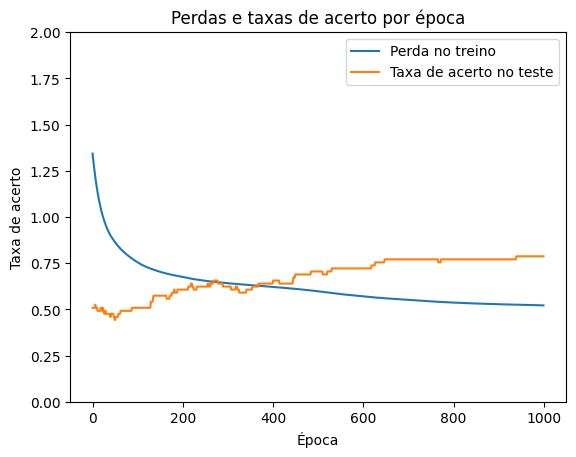

In [ ]:
plt.plot(perdas)
plt.plot(taxas_acerto)
plt.title('Perdas e taxas de acerto por época')
plt.legend(['Perda no treino', 'Taxa de acerto no teste'])
plt.xlabel('Época')
plt.ylabel('Taxa de acerto')
plt.ylim(0,2)
plt.show()

In [ ]:
variaveis = obter_pesos_vies(6,9,4)
pesos1, vies1, pesos2, vies2, pesos_final, vies_final = variaveis

otimizador_treino = tf.optimizers.SGD(learning_rate=0.01)

perdas = []
taxas_acerto = []

def neuronio(x, pesos, vies):
  return tf.add(tf.matmul(x, pesos), vies)

for epoca in range(QUANTIDADE_EPOCAS*2):
  with tf.GradientTape() as tape:
    treino1 = tf.nn.relu(neuronio(X_treino, pesos1, vies1))
    treino2 = tf.nn.relu(neuronio(treino1, pesos2, vies2))
    treino3 = tf.sigmoid(neuronio(treino2, pesos_final, vies_final))
    custo = calculadora_perda(y_treino, treino3)

  perdas.append(custo.numpy())

  teste1 = tf.nn.relu(neuronio(X_teste, pesos1, vies1))
  teste2 = tf.nn.relu(neuronio(teste1, pesos2, vies2))
  teste3 = tf.sigmoid(neuronio(teste2, pesos_final, vies_final))

  acertos = np.mean(y_teste.numpy() == ((teste3.numpy() > 0.5) *1))
  taxas_acerto.append(acertos)

  gradientes = tape.gradient(custo, variaveis)
  otimizador_treino.apply_gradients(zip(gradientes, variaveis))

In [ ]:
print(f'Menor custo obtido com ReLU nas camadas ocultas: {min(perdas)}')
print(f'Maior taxa de acerto obtida com ReLU nas camadas ocultas: {max(taxas_acerto)}')

Menor custo obtido com ReLU nas camadas ocultas: 0.5034579634666443
Maior taxa de acerto obtida com ReLU nas camadas ocultas: 0.8032786885245902


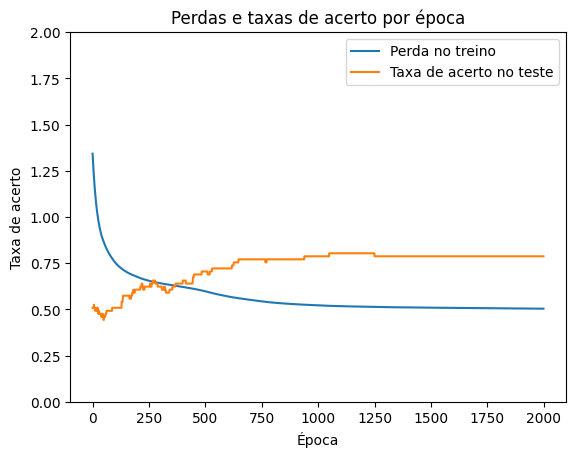

In [ ]:
plt.plot(perdas)
plt.plot(taxas_acerto)
plt.title('Perdas e taxas de acerto por época')
plt.legend(['Perda no treino', 'Taxa de acerto no teste'])
plt.xlabel('Época')
plt.ylabel('Taxa de acerto')
plt.ylim(0,2)
plt.show()